## Import Library

In [1]:
!pip install -U albumentations

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 7.5 MB/s eta 0:00:00
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.20
    Uninstalling albucore-0.0.20:
      Successfully uninstalled albucore-0.0.20
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.4.21
    Uninstalling albumentations-1.4.21:
      Successfully uninstalled albumentations-1.4.21


In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import cv2 as cv
from PIL import Image
from os import listdir
from pathlib import Path
import albumentations as A
from os.path import join, isdir
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import StratifiedKFold

import torch
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam
from torchvision import models
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.models import resnet50, efficientnet_b7
from sklearn.metrics import confusion_matrix, accuracy_score

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

## Helper

In [3]:
BATCH_SIZE = 32
EPOCH = 100
LEARNING_RATE = 0.001
CLASSES = 2
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
def create_labels(root_dir):
    data = []
    train_dir = os.path.join(root_dir, 'train')
    
    for subject_dir in os.listdir(train_dir):
        subject_path = os.path.join(train_dir, subject_dir)
        for category in os.listdir(subject_path):
            category_path = os.path.join(subject_path, category)
                
            if category == 'fall':
                for fall_type in os.listdir(category_path):
                    fall_type_path = os.path.join(category_path, fall_type)
                    if os.path.isdir(fall_type_path):
                        for file in os.listdir(fall_type_path):
                            if file.endswith(('.jpg', '.png', '.jpeg')): 
                                file_path = os.path.join(fall_type_path, file)
                                relative_path = os.path.relpath(file_path, train_dir)
                                data.append({
                                    'id': relative_path,
                                    'subject': subject_dir,
                                    'category': category,
                                    'movement_type': fall_type,
                                    'label': 1 
                                })
                                
            elif category == 'non_fall':
                for activity in os.listdir(category_path):
                    activity_path = os.path.join(category_path, activity)
                    if os.path.isdir(activity_path):
                        for file in os.listdir(activity_path):
                            if file.endswith(('.jpg', '.png', '.jpeg')): 
                                file_path = os.path.join(activity_path, file)
                                relative_path = os.path.relpath(file_path, train_dir)
                                data.append({
                                    'id': relative_path,
                                    'subject': subject_dir,
                                    'category': category,
                                    'movement_type': activity,
                                    'label': 0 
                                })
    
    df = pd.DataFrame(data)
    df = df.sort_values('id').reset_index(drop=True)
    
    return df

In [5]:
def preview(df, root_dir, num_images=9):
    plt.figure(figsize=(15, 10))
    samples = df.sample(n=num_images)
    
    for idx, (i, row) in enumerate(samples.iterrows(), 1):
        img_path = os.path.join(root_dir, 'train', row['id'])
        img = cv.imread(img_path)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB) 
        
        plt.subplot(3, 3, idx)
        plt.imshow(img)
        plt.axis('off')
        
        title = f"Label: {'Fall' if row['label']==1 else 'Non-Fall'}\n{row['movement_type']}"
        plt.title(title)
    
    plt.tight_layout()
    plt.show()

In [6]:
def training(model, data_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(data_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(data_loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [7]:
def validate(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(data_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / len(data_loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

## Dataset

In [8]:
train_dir = "/kaggle/input/data-slayer-2-0-dataset/" 
test_dir = "/kaggle/input/data-slayer-2-0-dataset/test/"
df = create_labels(train_dir)

df.to_csv('train_labels.csv', index=False)

In [9]:
print(f"Dataset Statistics: \nTotal samples train: {len(df)}")

Dataset Statistics: 
Total samples train: 4294


In [10]:
print(f"Samples per category: \n{df['category'].value_counts()}")

Samples per category: 
category
non_fall    2748
fall        1546
Name: count, dtype: int64


In [11]:
print(f"Samples per movement type: \n{df['movement_type'].value_counts()}")

Samples per movement type: 
movement_type
3_picking           170
4_picking           166
4_stretching        144
4_walking           134
4_jumping           128
3_walking           126
3_stretching        124
3_jumping           124
4_squat             122
4_laying            122
3_laying            118
3_squat             118
2_picking           113
1_stretching        111
2_stretching        108
4_sitting_falls     102
2_walking           100
1_picking            96
2_squat              91
2_jumping            90
1_squat              90
1_jumping            89
1_laying             89
1_walking            88
2_laying             87
3_right_falls        86
3_standing_falls     85
3_sitting_falls      81
3_forward_falls      77
3_backward_falls     74
2_sitting_falls      71
1_standing_falls     69
4_right_falls        69
4_standing_falls     68
3_left_falls         67
1_sitting_falls      66
2_standing_falls     66
4_forward_falls      63
4_backward_falls     62
4_left_falls         6

In [12]:
print(f"Samples per subject: \n{df['subject'].value_counts()}")

Samples per subject: 
subject
subject-3    1250
subject-4    1241
subject-2     918
subject-1     885
Name: count, dtype: int64


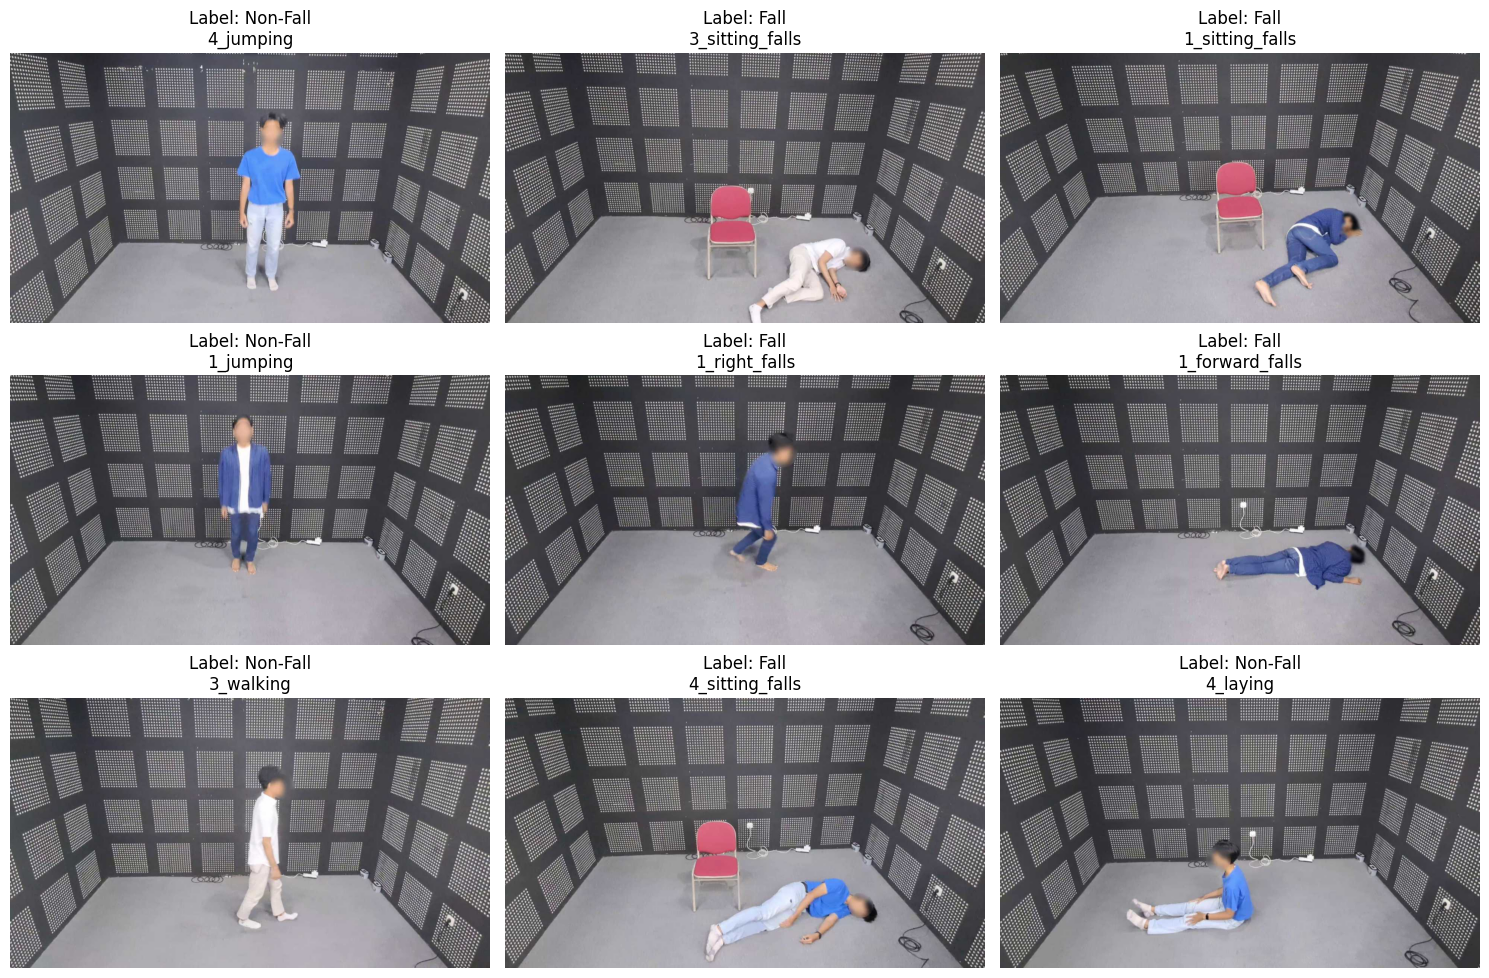

In [13]:
preview(df, "/kaggle/input/data-slayer-2-0-dataset/")

## Data Preprocessing

In [14]:
train_transforms = A.Compose([
    A.Resize(224, 224), 
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  
    ToTensorV2()
])

val_transforms = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

test_transforms = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

In [15]:
class FallDetectionDataset(Dataset):
    def __init__(self, df, root_dir, transform=None, is_test=False):
        self.df = df
        self.root_dir = root_dir
        self.transform = transform
        self.is_test = is_test

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if self.is_test:
            img_path = os.path.join(self.root_dir, self.df.iloc[idx]['id']) 
        else:
            img_path = os.path.join(self.root_dir, 'train', self.df.iloc[idx]['id'])

        image = cv.imread(img_path)
        if image is None:
            print(f"Warning: Unable to read image at {img_path}")
            image = np.zeros((224, 224, 3), dtype=np.uint8)
        else:
            image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        if self.is_test:
            return image
        else:
            label = self.df.iloc[idx]['label']
            return image, label

In [16]:
test_data = []

for file in os.listdir(test_dir):
    if file.endswith(('.jpg', '.png', '.jpeg')):
        test_data.append({'id': file})
test_df = pd.DataFrame(test_data)

In [17]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

train_idx, val_idx = next(skf.split(df, df['label']))
train_df = df.iloc[train_idx].reset_index(drop=True)
val_df = df.iloc[val_idx].reset_index(drop=True)

In [18]:
train_dataset = FallDetectionDataset(train_df, root_dir=train_dir, transform=train_transforms)
val_dataset = FallDetectionDataset(val_df, root_dir=train_dir, transform=val_transforms)
test_dataset = FallDetectionDataset(test_df, root_dir=test_dir, transform=test_transforms, is_test=True)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [19]:
print("Number of training samples:", len(train_dataset))
print("Number of validation samples:", len(val_dataset))
print("Number of test samples:", len(test_dataset))

Number of training samples: 3864
Number of validation samples: 430
Number of test samples: 2152


In [20]:
print(f"Test dir: {test_dir} \n{test_df.head()}")

Test dir: /kaggle/input/data-slayer-2-0-dataset/test/ 
               id
0  6e001dec60.jpg
1  ae5930d570.jpg
2  f0158f240a.jpg
3  62c5b268ef.jpg
4  91d93bb89b.jpg


## Training

In [22]:
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, CLASSES) 
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, verbose=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 185MB/s] 
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn

In [21]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(EPOCH):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    val_loss /= total
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    print(f"Epoch {epoch + 1}/{EPOCH}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_resnet50_model.pth")
        print("Best model saved!")

Epoch 1/100


100%|██████████| 14/14 [00:02<00:00,  6.70it/s]


Train Loss: 0.2404, Train Accuracy: 0.9086
Val Loss: 0.2308, Val Accuracy: 0.9419
Best model saved!
Epoch 2/100


100%|██████████| 14/14 [00:02<00:00,  6.72it/s]


Train Loss: 0.0700, Train Accuracy: 0.9746
Val Loss: 0.1880, Val Accuracy: 0.9093
Epoch 3/100


100%|██████████| 14/14 [00:01<00:00,  7.41it/s]


Train Loss: 0.0652, Train Accuracy: 0.9764
Val Loss: 0.1286, Val Accuracy: 0.9674
Best model saved!
Epoch 4/100


100%|██████████| 14/14 [00:01<00:00,  7.43it/s]


Train Loss: 0.0264, Train Accuracy: 0.9912
Val Loss: 0.0122, Val Accuracy: 1.0000
Best model saved!
Epoch 5/100


100%|██████████| 14/14 [00:01<00:00,  7.35it/s]


Train Loss: 0.0385, Train Accuracy: 0.9876
Val Loss: 0.1026, Val Accuracy: 0.9581
Epoch 6/100


100%|██████████| 14/14 [00:01<00:00,  7.37it/s]


Train Loss: 0.0452, Train Accuracy: 0.9858
Val Loss: 0.0249, Val Accuracy: 0.9953
Epoch 7/100


100%|██████████| 14/14 [00:01<00:00,  7.45it/s]


Train Loss: 0.0308, Train Accuracy: 0.9891
Val Loss: 0.0116, Val Accuracy: 0.9977
Epoch 8/100


100%|██████████| 14/14 [00:01<00:00,  7.52it/s]


Train Loss: 0.0308, Train Accuracy: 0.9894
Val Loss: 0.1432, Val Accuracy: 0.9419
Epoch 9/100


100%|██████████| 14/14 [00:01<00:00,  7.48it/s]


Train Loss: 0.0145, Train Accuracy: 0.9943
Val Loss: 0.0020, Val Accuracy: 1.0000
Epoch 10/100


100%|██████████| 14/14 [00:01<00:00,  7.41it/s]


Train Loss: 0.0100, Train Accuracy: 0.9972
Val Loss: 0.0135, Val Accuracy: 0.9953
Epoch 11/100


100%|██████████| 14/14 [00:01<00:00,  7.38it/s]


Train Loss: 0.0061, Train Accuracy: 0.9977
Val Loss: 0.0004, Val Accuracy: 1.0000
Epoch 12/100


100%|██████████| 14/14 [00:01<00:00,  7.19it/s]


Train Loss: 0.0011, Train Accuracy: 0.9997
Val Loss: 0.0040, Val Accuracy: 1.0000
Epoch 13/100


100%|██████████| 14/14 [00:01<00:00,  7.43it/s]


Train Loss: 0.0008, Train Accuracy: 1.0000
Val Loss: 0.0001, Val Accuracy: 1.0000
Epoch 14/100


100%|██████████| 14/14 [00:01<00:00,  7.46it/s]


Train Loss: 0.0002, Train Accuracy: 1.0000
Val Loss: 0.0001, Val Accuracy: 1.0000
Epoch 15/100


100%|██████████| 14/14 [00:01<00:00,  7.39it/s]


Train Loss: 0.0002, Train Accuracy: 1.0000
Val Loss: 0.0003, Val Accuracy: 1.0000
Epoch 16/100


100%|██████████| 14/14 [00:01<00:00,  7.38it/s]


Train Loss: 0.0002, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 17/100


100%|██████████| 14/14 [00:01<00:00,  7.42it/s]


Train Loss: 0.0001, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 18/100


100%|██████████| 14/14 [00:01<00:00,  7.55it/s]


Train Loss: 0.0002, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 19/100


100%|██████████| 14/14 [00:02<00:00,  6.71it/s]


Train Loss: 0.0001, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 20/100


100%|██████████| 14/14 [00:01<00:00,  7.37it/s]


Train Loss: 0.0001, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 21/100


100%|██████████| 14/14 [00:01<00:00,  7.39it/s]


Train Loss: 0.0000, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 22/100


100%|██████████| 14/14 [00:01<00:00,  7.39it/s]


Train Loss: 0.0001, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 23/100


100%|██████████| 14/14 [00:01<00:00,  7.47it/s]


Train Loss: 0.0000, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 24/100


100%|██████████| 14/14 [00:01<00:00,  7.48it/s]


Train Loss: 0.0000, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 25/100


100%|██████████| 14/14 [00:01<00:00,  7.48it/s]


Train Loss: 0.0002, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 26/100


100%|██████████| 14/14 [00:01<00:00,  7.55it/s]


Train Loss: 0.0000, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 27/100


100%|██████████| 14/14 [00:01<00:00,  7.30it/s]


Train Loss: 0.0001, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 28/100


100%|██████████| 14/14 [00:01<00:00,  7.43it/s]


Train Loss: 0.0000, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 29/100


100%|██████████| 14/14 [00:02<00:00,  6.73it/s]


Train Loss: 0.0000, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 30/100


100%|██████████| 14/14 [00:01<00:00,  7.33it/s]


Train Loss: 0.0001, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 31/100


100%|██████████| 14/14 [00:01<00:00,  7.51it/s]


Train Loss: 0.0001, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 32/100


100%|██████████| 14/14 [00:01<00:00,  7.50it/s]


Train Loss: 0.0001, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 33/100


100%|██████████| 14/14 [00:01<00:00,  7.39it/s]


Train Loss: 0.0001, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 34/100


100%|██████████| 14/14 [00:01<00:00,  7.46it/s]


Train Loss: 0.0000, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 35/100


100%|██████████| 14/14 [00:01<00:00,  7.43it/s]


Train Loss: 0.0000, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 36/100


100%|██████████| 14/14 [00:01<00:00,  7.54it/s]


Train Loss: 0.0000, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 37/100


100%|██████████| 14/14 [00:01<00:00,  7.51it/s]


Train Loss: 0.0000, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 38/100


100%|██████████| 14/14 [00:01<00:00,  7.46it/s]


Train Loss: 0.0000, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 39/100


100%|██████████| 14/14 [00:02<00:00,  6.81it/s]


Train Loss: 0.0000, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 40/100


100%|██████████| 14/14 [00:01<00:00,  7.47it/s]


Train Loss: 0.0000, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 41/100


100%|██████████| 14/14 [00:01<00:00,  7.52it/s]


Train Loss: 0.0000, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 42/100


100%|██████████| 14/14 [00:01<00:00,  7.46it/s]


Train Loss: 0.0001, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 43/100


100%|██████████| 14/14 [00:01<00:00,  7.49it/s]


Train Loss: 0.0000, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 44/100


100%|██████████| 14/14 [00:01<00:00,  7.35it/s]


Train Loss: 0.0000, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 45/100


100%|██████████| 14/14 [00:01<00:00,  7.51it/s]


Train Loss: 0.0000, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 46/100


100%|██████████| 14/14 [00:01<00:00,  7.48it/s]


Train Loss: 0.0000, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 47/100


100%|██████████| 14/14 [00:01<00:00,  7.50it/s]


Train Loss: 0.0001, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 48/100


100%|██████████| 14/14 [00:01<00:00,  7.53it/s]


Train Loss: 0.0000, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 49/100


100%|██████████| 14/14 [00:01<00:00,  7.46it/s]


Train Loss: 0.0000, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 50/100


100%|██████████| 14/14 [00:01<00:00,  7.36it/s]


Train Loss: 0.0000, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 51/100


100%|██████████| 14/14 [00:01<00:00,  7.49it/s]


Train Loss: 0.0000, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 52/100


100%|██████████| 14/14 [00:01<00:00,  7.38it/s]


Train Loss: 0.0000, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 53/100


100%|██████████| 14/14 [00:01<00:00,  7.44it/s]


Train Loss: 0.0000, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 54/100


100%|██████████| 14/14 [00:01<00:00,  7.53it/s]


Train Loss: 0.0000, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 55/100


100%|██████████| 14/14 [00:01<00:00,  7.25it/s]


Train Loss: 0.0000, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 56/100


100%|██████████| 14/14 [00:02<00:00,  6.40it/s]


Train Loss: 0.0000, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 57/100


100%|██████████| 14/14 [00:01<00:00,  7.24it/s]


Train Loss: 0.0000, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 58/100


100%|██████████| 14/14 [00:01<00:00,  7.25it/s]


Train Loss: 0.0001, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 59/100


100%|██████████| 14/14 [00:01<00:00,  7.50it/s]


Train Loss: 0.0000, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 60/100


100%|██████████| 14/14 [00:01<00:00,  7.47it/s]


Train Loss: 0.0000, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 61/100


100%|██████████| 14/14 [00:01<00:00,  7.57it/s]


Train Loss: 0.0000, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 62/100


100%|██████████| 14/14 [00:01<00:00,  7.52it/s]


Train Loss: 0.0000, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 63/100


100%|██████████| 14/14 [00:01<00:00,  7.53it/s]


Train Loss: 0.0000, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 64/100


100%|██████████| 14/14 [00:01<00:00,  7.44it/s]


Train Loss: 0.0000, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 65/100


100%|██████████| 14/14 [00:01<00:00,  7.41it/s]


Train Loss: 0.0000, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 66/100


100%|██████████| 14/14 [00:01<00:00,  7.54it/s]


Train Loss: 0.0000, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 67/100


100%|██████████| 14/14 [00:01<00:00,  7.40it/s]


Train Loss: 0.0000, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 68/100


100%|██████████| 14/14 [00:01<00:00,  7.49it/s]


Train Loss: 0.0000, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 69/100


100%|██████████| 14/14 [00:01<00:00,  7.43it/s]


Train Loss: 0.0000, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 70/100


100%|██████████| 14/14 [00:01<00:00,  7.45it/s]


Train Loss: 0.0001, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 71/100


100%|██████████| 14/14 [00:01<00:00,  7.53it/s]


Train Loss: 0.0000, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 72/100


100%|██████████| 14/14 [00:01<00:00,  7.49it/s]


Train Loss: 0.0000, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 73/100


100%|██████████| 14/14 [00:02<00:00,  6.29it/s]


Train Loss: 0.0000, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 74/100


100%|██████████| 14/14 [00:01<00:00,  7.37it/s]


Train Loss: 0.0000, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 75/100


100%|██████████| 14/14 [00:01<00:00,  7.52it/s]


Train Loss: 0.0000, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 76/100


100%|██████████| 14/14 [00:01<00:00,  7.49it/s]


Train Loss: 0.0000, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 77/100


100%|██████████| 14/14 [00:01<00:00,  7.53it/s]


Train Loss: 0.0000, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 78/100


100%|██████████| 14/14 [00:01<00:00,  7.45it/s]


Train Loss: 0.0000, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 79/100


100%|██████████| 14/14 [00:01<00:00,  7.43it/s]


Train Loss: 0.0000, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 80/100


100%|██████████| 14/14 [00:01<00:00,  7.44it/s]


Train Loss: 0.0000, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 81/100


100%|██████████| 14/14 [00:01<00:00,  7.37it/s]


Train Loss: 0.0000, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 82/100


100%|██████████| 14/14 [00:01<00:00,  7.54it/s]


Train Loss: 0.0000, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 83/100


100%|██████████| 14/14 [00:01<00:00,  7.36it/s]


Train Loss: 0.0000, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 84/100


100%|██████████| 14/14 [00:01<00:00,  7.37it/s]


Train Loss: 0.0000, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 85/100


100%|██████████| 14/14 [00:01<00:00,  7.37it/s]


Train Loss: 0.0000, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 86/100


100%|██████████| 14/14 [00:01<00:00,  7.43it/s]


Train Loss: 0.0000, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 87/100


100%|██████████| 14/14 [00:01<00:00,  7.46it/s]


Train Loss: 0.0000, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 88/100


100%|██████████| 14/14 [00:01<00:00,  7.38it/s]


Train Loss: 0.0000, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 89/100


100%|██████████| 14/14 [00:01<00:00,  7.52it/s]


Train Loss: 0.0000, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 90/100


100%|██████████| 14/14 [00:01<00:00,  7.22it/s]


Train Loss: 0.0000, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 91/100


100%|██████████| 14/14 [00:01<00:00,  7.45it/s]


Train Loss: 0.0000, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 92/100


100%|██████████| 14/14 [00:01<00:00,  7.40it/s]


Train Loss: 0.0001, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 93/100


100%|██████████| 14/14 [00:01<00:00,  7.31it/s]


Train Loss: 0.0000, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 94/100


100%|██████████| 14/14 [00:01<00:00,  7.41it/s]


Train Loss: 0.0000, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 95/100


100%|██████████| 14/14 [00:01<00:00,  7.45it/s]


Train Loss: 0.0000, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 96/100


100%|██████████| 14/14 [00:01<00:00,  7.47it/s]


Train Loss: 0.0000, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 97/100


100%|██████████| 14/14 [00:01<00:00,  7.44it/s]


Train Loss: 0.0000, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 98/100


100%|██████████| 14/14 [00:01<00:00,  7.50it/s]


Train Loss: 0.0001, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 99/100


100%|██████████| 14/14 [00:01<00:00,  7.37it/s]


Train Loss: 0.0000, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000
Epoch 100/100


100%|██████████| 14/14 [00:02<00:00,  6.31it/s]

Train Loss: 0.0001, Train Accuracy: 1.0000
Val Loss: 0.0000, Val Accuracy: 1.0000
Best Validation Accuracy: 1.0000


In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [23]:
test_preds = []
model.load_state_dict(torch.load("best_resnet50_model.pth", weights_only=True))

model.eval()
with torch.no_grad():
    for images in tqdm(test_loader):
        images = images.to(DEVICE)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        test_preds.extend(preds.cpu().numpy())

submission = pd.DataFrame({'id': test_df['id'], 'label': test_preds})
submission.to_csv('submission.csv', index=False)

FileNotFoundError: [Errno 2] No such file or directory: 'best_resnet50_model.pth'